In [9]:
# Create Spark Session

from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("Read Voter File Data") \
        .getOrCreate()

In [2]:
# global variables 
class_bucket_name = "winter-2024-voter-file"
local_bucket_name = "pstat135-final-project1"
class_folder_name = "VM2Uniform"  

In [3]:
""" Use these functions to [read/write] [parquet files/data frames] [from/to] Google Cloud"""

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, count

def read_parquet_file(spark_session, file_path):
    """
    Reads a Parquet file and returns a Spark DataFrame.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    file_path (str): The path to the Parquet file.

    Returns:
    DataFrame: A Spark DataFrame containing the data from the Parquet file.
    """

    # Read the Parquet file
    df = (
        spark_session.read
        .format("parquet")
        .option("header", "true")
        .option("inferSchema", "true")
        .load(file_path)
    )

    return df


def write_df_to_gcs_parquet(spark_session, df, bucket_name, file_path):
    """
    Writes a Spark DataFrame to a Google Cloud Storage bucket as a Parquet file.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    df (DataFrame): The Spark DataFrame to write.
    bucket_name (str): The name of the Google Cloud Storage bucket.
    file_path (str): The file path within the bucket where the Parquet file will be saved.
    """
    
    # Define the GCS path
    gcs_path = f"gs://{bucket_name}/data_cleaned/{file_path}"

    # Write the DataFrame as a Parquet file to GCS
    df.write.parquet(gcs_path, mode='overwrite')
    

def list_content(bucket_name):
    """
    Lists all the blobs in the bucket.
    
    Parameters: 
    bucket_name (str): The name of the Google Cloud Storage bucket. 
    """
    storage_client = storage.Client()
    content = storage_client.list_blobs(bucket_name)
    
    for file in content:
        print(file.name)

def column_missing_percentage1(df):
    """
    Calculate the percentage of missing values for each column in the DataFrame.
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with two columns: 'Column_Name' and 'Missing_Percentage'.
    """
    missing_percentage_data = []
    total_count = df.count()
    
    for c in df.columns:
        missing_count = df.filter(col(c).isNull() | (col(c) == '')).count()
        missing_percentage = (missing_count / total_count) * 100
        missing_percentage_data.append((c, missing_percentage))
    
    missing_percentage_df = spark.createDataFrame(missing_percentage_data, ["Column_Name", "Missing_Percentage"])
    return missing_percentage_df

In [4]:
df = read_parquet_file(spark, "gs://pstat135-final-project1/data_cleaned/dataset_young_demographic")

In [ ]:
df.printSchema()

In [5]:
from pyspark.sql.functions import when, col, regexp_replace
from pyspark.ml.feature import StringIndexer

def clean_dataset(df):
    """
    Clean our dataset by applying the following: 
        1) Convert 'CommercialData_EstHomeValue' from string to int data type
        2) Extract state from `LALVOTERID`
        3) Convert `Voters_Gender` into a 0/1 depending on Gender
        4) Fill missing values in 'General_2020', 'PresidentialPrimary_2020', 'Primary_2020'
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with the necessary columns. 
    """
    df_num = df.withColumn("CommercialData_EstHomeValue_in_Dollars", regexp_replace("CommercialData_EstHomeValue", "\\$", "").cast("int"))    
    df_with_state = df_num.withColumn("State", col("LALVOTERID").substr(4, 2))
    cleaned_df = df_with_state.filter(df_with_state.Voters_Gender.isNotNull())
    converted_df = cleaned_df.withColumn("Gender", when(col("Voters_Gender") == "M", 1).otherwise(0))
    converted_df = converted_df.filter(converted_df.CommercialData_EstimatedHHIncome.isNotNull())
    
    indexer = StringIndexer(inputCol="CommercialData_EstimatedHHIncome", outputCol="CommercialData_EstimatedHHIncome_ctg", handleInvalid="skip")

    # Fit and transform the DataFrame
    model = indexer.fit(converted_df)
    df_categorical = model.transform(converted_df)
    
    df_a = df_categorical.fillna({'General_2020': 'N'})
    df_b = df_a.fillna({'PresidentialPrimary_2020': 'N'})
    df_c = df_b.fillna({'Primary_2020': 'N'})
    
    df_final = df_c.drop("Voters_StateVoterID")
    return df_final

In [6]:
df_final = clean_dataset(df)

In [ ]:
df_final.printSchema()

In [ ]:
# Analyzing Home Prices across States

df_final.createOrReplaceTempView("home_prices")

# SQL query for mean home prices by state
mean_prices_sql = """
SELECT State, AVG(CommercialData_EstHomeValue_in_Dollars) as MeanHomePrice
FROM home_prices
GROUP BY State
"""
mean_prices = spark.sql(mean_prices_sql)

# SQL query for median home prices by state
# Note: Spark SQL does not have a direct median function. We use percentile_approx for an approximation.
median_prices_sql = """
SELECT State, percentile_approx(CommercialData_EstHomeValue_in_Dollars, 0.5) as MedianHomePrice
FROM home_prices
GROUP BY State
"""
median_prices = spark.sql(median_prices_sql)

In [ ]:
df_mean_rounded = mean_prices.withColumn("MeanHomePrice", col("MeanHomePrice").cast("int"))
joined_df = df_mean_rounded.join(median_prices, df_mean_rounded.State == median_prices.State)
mean_median_df = joined_df.select(df_mean_rounded.State, "MeanHomePrice", "MedianHomePrice")
mean_median_pandas = mean_median_df.toPandas()
print(mean_median_pandas)

In [10]:
## Bar Plot for voting trends by Gender in the young voter demographic
from pyspark.sql.functions import col, count, when

gender_voting = df_final.groupBy("Gender").agg(
    (count(when(col("General_2020") == "Y", True)) / count("*")).alias("Percentage_Voted")
)

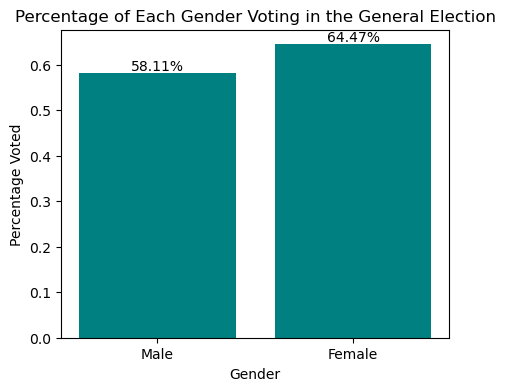

In [11]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = gender_voting.toPandas()

# Replace 0 and 1 with 'Female' and 'Male'
pandas_df['Gender'] = pandas_df['Gender'].replace({0: 'Female', 1: 'Male'})

# Plotting
plt.figure(figsize=(5, 4))
bars = plt.bar(pandas_df['Gender'], pandas_df['Percentage_Voted'], color='teal')

plt.xlabel('Gender')
plt.ylabel('Percentage Voted')
plt.title('Percentage of Each Gender Voting in the General Election')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{round(yval*100, 2)}%", va='bottom', ha='center')

plt.show()

In [14]:
from pyspark.sql.functions import col, count
from pyspark.sql import functions as F

# Assuming 'df' is your DataFrame
df = df_final.select("General_2020", "CommercialData_EstimatedHHIncome")

In [18]:
from pyspark.sql import functions as F

# Assuming 'df' is your DataFrame with 'CommercialData_EstimatedHHIncome' and 'General_2020'

# Group by income category and perform the calculations
income_voting_stats = df.groupBy("CommercialData_EstimatedHHIncome").agg(
    F.count("*").alias("Total_Count"),
    F.count(F.when(F.col("General_2020") == "Y", True)).alias("Voters_Count"),
    (F.count(F.when(F.col("General_2020") == "Y", True)) / F.count("*") * 100).alias("Percentage_Voters")
).orderBy("Percentage_Voters")

income_voting_stats.show()

+--------------------------------+-----------+------------+------------------+
|CommercialData_EstimatedHHIncome|Total_Count|Voters_Count| Percentage_Voters|
+--------------------------------+-----------+------------+------------------+
|                    $25000-34999|     146559|       70877| 48.36072844383491|
|                    $15000-24999|      90414|       44269|48.962550047559006|
|                    $35000-49999|     317951|      162049| 50.96665838446805|
|                     $1000-14999|      78361|       41061| 52.39979071221653|
|                    $50000-74999|     706580|      397507| 56.25789011859945|
|                    $75000-99999|     540698|      341486| 63.15651250790645|
|                  $100000-124999|     322785|      217654| 67.43002308037858|
|                  $125000-149999|     262403|      183893|  70.0803725567162|
|                  $150000-174999|     104466|       73858| 70.70051500009572|
|                  $175000-199999|     111895|      

In [19]:
pandas_df = income_voting_stats.toPandas()

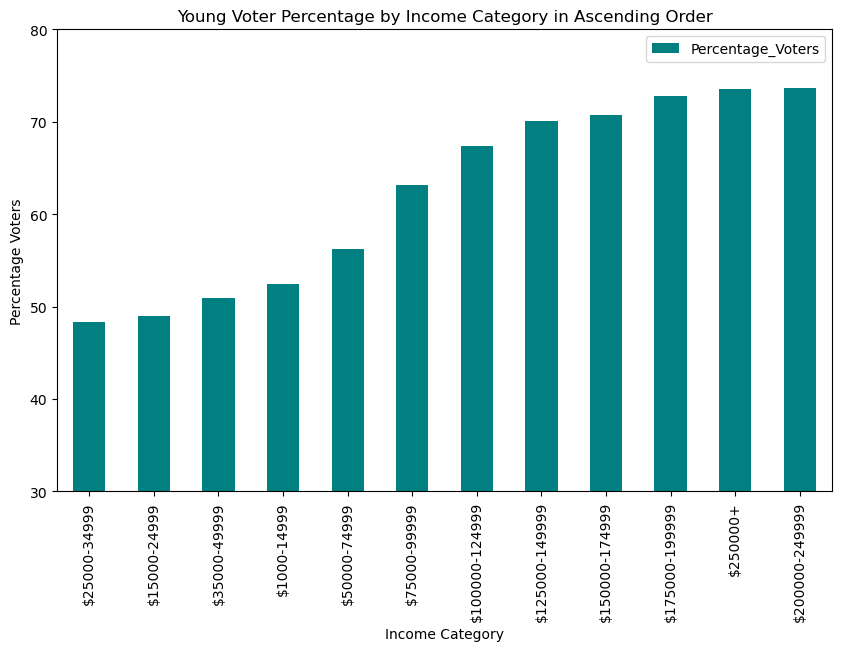

In [20]:
import matplotlib.pyplot as plt

# Assuming 'Income' is a category, we will use bar plot instead of histogram
pandas_df.plot(kind='bar', x='CommercialData_EstimatedHHIncome', y='Percentage_Voters', figsize=(10, 6), color = "teal")

plt.xlabel('Income Category')
plt.ylabel('Percentage Voters')
plt.title('Young Voter Percentage by Income Category in Ascending Order')
plt.ylim(30, 80)  # Set the limit for y-axis
plt.show()

In [21]:
# Analyzing Ethnic Groups among Young Voter demographics
from pyspark.sql import functions as F
from pyspark.sql.functions import col

df_ethnic = df_final.select("EthnicGroups_EthnicGroup1Desc", "General_2020")
df_ethnic_groups = df_ethnic.filter(col("EthnicGroups_EthnicGroup1Desc").isNotNull())

from pyspark.sql import functions as F

distinct_counts_ethnic_df = df_ethnic_groups.groupBy("EthnicGroups_EthnicGroup1Desc").agg(
    F.count("*").alias("Total_Count"),
    F.count(F.when(F.col("General_2020") == "Y", True)).alias("Voters_Count"),
    (F.count(F.when(F.col("General_2020") == "Y", True)) / F.count("*") * 100).alias("Percentage_Voters")
).orderBy("Percentage_Voters")

In [22]:
distinct_counts_ethnic_df.show(truncate=False)

+-----------------------------+-----------+------------+------------------+
|EthnicGroups_EthnicGroup1Desc|Total_Count|Voters_Count|Percentage_Voters |
+-----------------------------+-----------+------------+------------------+
|Likely African-American      |348029     |170585      |49.014593611451915|
|Hispanic and Portuguese      |512456     |290363      |56.66105968122142 |
|Other                        |79243      |50605       |63.86053026765771 |
|European                     |1608418    |1035386     |64.37294285440724 |
|East and South Asian         |103113     |69299       |67.20685073657056 |
+-----------------------------+-----------+------------+------------------+



In [23]:
pandas_df = distinct_counts_ethnic_df.toPandas()

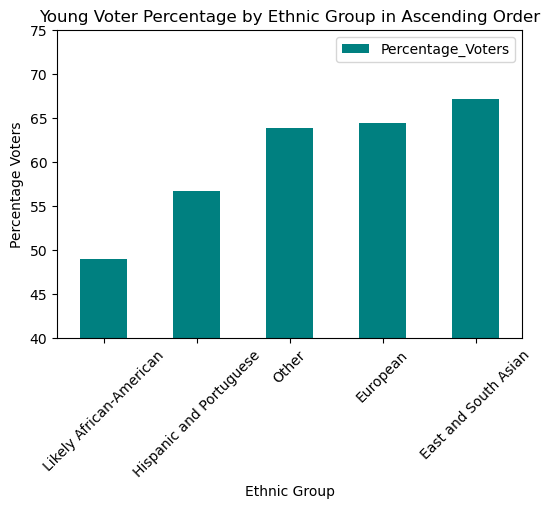

In [24]:
import matplotlib.pyplot as plt

# Your existing code for plotting
pandas_df.plot(kind='bar', x='EthnicGroups_EthnicGroup1Desc', y='Percentage_Voters', figsize=(6, 4), color="teal")

plt.xlabel('Ethnic Group')
plt.ylabel('Percentage Voters')
plt.title('Young Voter Percentage by Ethnic Group in Ascending Order')
plt.ylim(40, 75) 

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

In [25]:
df_education = df_final.select("CommercialData_Education", "General_2020")

df_education_summary = df_education.groupBy("CommercialData_Education").agg(
    F.count("*").alias("Total_Count"),
    F.count(F.when(F.col("General_2020") == "Y", True)).alias("Voters_Count"),
    (F.count(F.when(F.col("General_2020") == "Y", True)) / F.count("*") * 100).alias("Percentage_Voters")
).orderBy("Percentage_Voters")

In [26]:
df_education_summary.show()

+------------------------+-----------+------------+------------------+
|CommercialData_Education|Total_Count|Voters_Count| Percentage_Voters|
+------------------------+-----------+------------+------------------+
|    Less than HS Dipl...|         26|          10| 38.46153846153847|
|    Vocational Techni...|         68|          29| 42.64705882352941|
|                    null|    1819857|     1046637| 57.51204627616345|
|    Less than HS Dipl...|      86895|       51238| 58.96541803325853|
|    HS Diploma - Extr...|      26234|       15523|59.171304414119085|
|    Some College -Ext...|      12581|        8218| 65.32072172323345|
|    Bach Degree - Ext...|      15269|       10028|  65.6755517715633|
|     HS Diploma - Likely|     178307|      117859| 66.09891927966933|
|    Some College - Li...|     573001|      392084| 68.42640763279645|
|    Grad Degree - Ext...|       5355|        3712| 69.31839402427637|
|    Bach Degree - Likely|     159465|      113388| 71.10525820713009|
|    G

In [31]:
pandas_df1 = df_education_summary.toPandas()

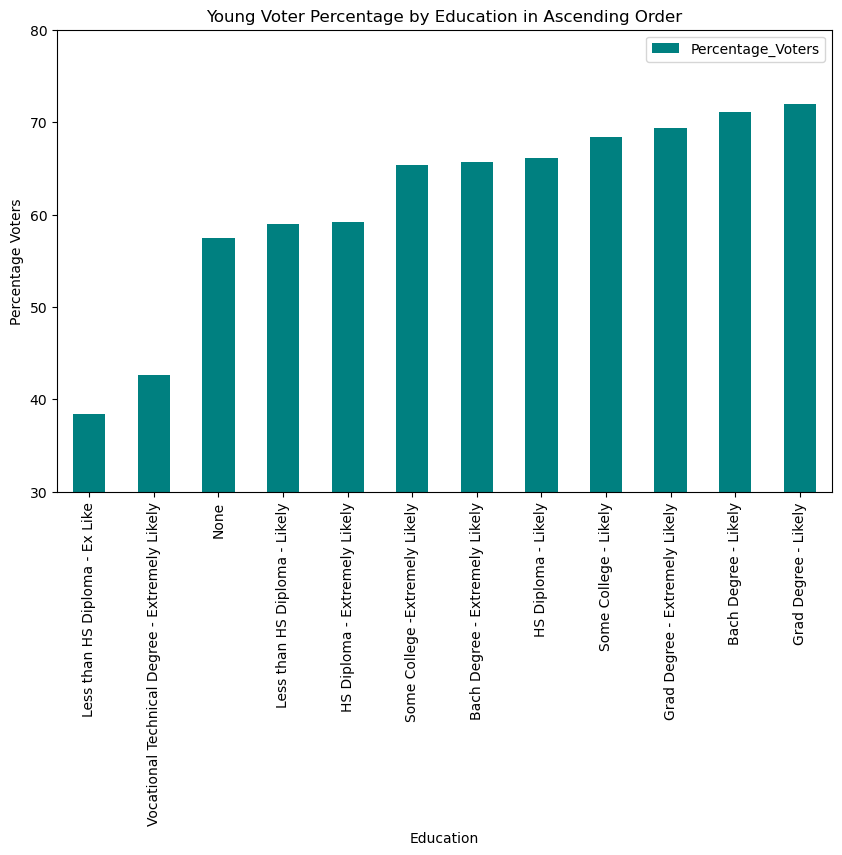

In [32]:
import matplotlib.pyplot as plt

# Assuming 'Income' is a category, we will use bar plot instead of histogram
pandas_df1.plot(kind='bar', x='CommercialData_Education', y='Percentage_Voters', figsize=(10, 6), color = "teal")

plt.xlabel('Education')
plt.ylabel('Percentage Voters')
plt.title('Young Voter Percentage by Education in Ascending Order')
plt.ylim(30, 80)  # Set the limit for y-axis
plt.show()